## Set up notebook and import data

In [124]:
# import packages and configure notebook
import psycopg2 as pg
import pandas as pd
import numpy as np
import pickle 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='paper', style='whitegrid', font_scale=1.2)

In [125]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  # connecting to local version of psql
    'dbname': 'complaints_db',    # DB that we are connecting to
    'port': 5432          # port we opened on AWS
}

connection = pg.connect(**connection_args)  # What is that "**" there??

In [139]:
# pull in complaints data
query = "SELECT * FROM complaints;"
df = pd.read_sql(query, connection)
df.shape

(33358, 27)

## Data Processing

### Check for duplicates

In [140]:
df.duplicated().sum()

631

In [141]:
# yikes! I guess there are a bunch of duplicates... going to eyeball some to be sure
df[df.duplicated(keep=False)].sort_values(by='unique_mos_id').head(6)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
1062,110,Evan,Mele,001 PCT,4939,37703,7,2017,1,2018,...,29,None,Male,NaN,Force,Pepper spray,1.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Command Discipline A)
1063,110,Evan,Mele,001 PCT,4939,37703,7,2017,1,2018,...,29,None,Male,NaN,Force,Pepper spray,1.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Command Discipline A)
27831,454,Mayko,Matos,006 PCT,13660,36241,12,2016,5,2017,...,24,Hispanic,Male,36.0,Discourtesy,Word,50.0,Other violation of VTL,Arrest - other violation/crime,Unsubstantiated
27834,454,Mayko,Matos,006 PCT,13660,36241,12,2016,5,2017,...,24,Hispanic,Male,36.0,Discourtesy,Word,50.0,Other violation of VTL,Arrest - other violation/crime,Unsubstantiated
29863,641,Michael,Straniere,007 PCT,2385,8623,12,2004,11,2005,...,36,Black,Male,35.0,Discourtesy,Word,1.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,Unsubstantiated
29861,641,Michael,Straniere,007 PCT,2385,8623,12,2004,11,2005,...,36,Black,Male,35.0,Discourtesy,Word,1.0,PD suspected C/V of violation/crime - street,Arrest - other violation/crime,Unsubstantiated


In [142]:
# remove all but the first instance of every duplicate
df = df.drop_duplicates()
df.shape

(32727, 27)

### Check for outliers

In [143]:
df.describe()

,unique_mos_id,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,mos_age_incident,complainant_age_incident,precinct
count,32727.000000,32727.000000,32727.000000,32727.000000,32727.000000,32727.000000,32727.000000,32727.000000,28147.000000,32704.000000
mean,18160.217343,6450.242521,23916.100834,6.323372,2010.769579,6.472515,2011.573044,32.356709,32.504885,64.392521
std,9584.773239,7941.018478,11856.240144,3.364841,5.909515,3.343936,5.951548,6.032566,28.575508,31.502984
min,2.000000,0.000000,517.000000,1.000000,1985.000000,1.000000,1985.000000,20.000000,-4301.000000,0.000000
25%,9654.000000,1101.000000,13799.000000,3.000000,2007.000000,4.000000,2008.000000,28.000000,23.000000,43.000000
50%,19215.000000,3691.000000,25081.000000,6.000000,2012.000000,6.000000,2013.000000,31.000000,30.000000,67.000000
75%,25412.000000,7158.000000,34165.000000,9.000000,2015.000000,9.000000,2016.000000,36.000000,41.000000,81.000000
max,36374.000000,31977.000000,43703.000000,12.000000,2020.000000,12.000000,2020.000000,60.000000,101.000000,1000.000000


In [150]:
# remove impossibbly high and low complainant age
df['complainant_age_incident'] = df['complainant_age_incident'].apply(lambda x: np.where(x < 15,np.nan,x))

# check how that changed things:
df['complainant_age_incident'].describe()

# it's possible that the 101 value was a missing data value, but since there's not a spike in frequency at 101,
# I'll leave it in

count    27666.000000
mean        33.002602
std         12.037582
min         15.000000
25%         24.000000
50%         31.000000
75%         41.000000
max        101.000000
Name: complainant_age_incident, dtype: float64

### Clean target labels

In [151]:
# Combine all "substantiated" to a single label
df['disposition_clean'] = df['board_disposition']
mask = df['board_disposition'].str.startswith('Substantiated')
df.loc[mask, 'disposition_clean'] = 'Substantiated'

In [152]:
# create separate target labels for 1) conduct occurred, 2) conduct violated rules

# create dicts to map values
conduct_occurred_dict = {'Substantiated':1,'Exonerated':1,'Unsubstantiated':0}
conduct_violated_rules_dict = {'Substantiated':1,'Exonerated':0,'Unsubstantiated':0}

# create new target labels
df['ruling_conduct_occurred'] = df['disposition_clean'].map(conduct_occurred_dict)
df['ruling_conduct_violated_rules'] = df['disposition_clean'].map(conduct_violated_rules_dict)

### Create datetime and age fields

In [153]:
# create datetime fields; assume first day of the month for all
df['received_datetime'] = pd.to_datetime(df['year_received'].astype(str) + '/' + df['month_received'].astype(str) + '/01')
df['closed_datetime'] = pd.to_datetime(df['year_closed'].astype(str) + '/' + df['month_closed'].astype(str) + '/01')

In [154]:
df = df.sort_values(by = 'received_datetime')
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,allegation,precinct,contact_reason,outcome_description,board_disposition,disposition_clean,ruling_conduct_occurred,ruling_conduct_violated_rules,received_datetime,closed_datetime
5810,17403,Edward,Mullane,CD OP/D,0,517,9,1985,9,1985,...,Curse,83.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-09-01,1985-09-01
5812,17403,Edward,Mullane,CD OP/D,0,517,9,1985,9,1985,...,Arrest/D. A. T.,83.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-09-01,1985-09-01
5811,17403,Edward,Mullane,CD OP/D,0,517,9,1985,9,1985,...,Push/Shove,83.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-09-01,1985-09-01
10894,20619,Troy,Patterson,FAM SEC,2609,525,10,1985,10,1985,...,Dragged/Pulled,71.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-10-01,1985-10-01
10895,20619,Troy,Patterson,FAM SEC,2609,525,10,1985,10,1985,...,Arrest/Onlooker,71.0,Report of Crime Past/Present,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,1985-10-01,1985-10-01


In [155]:
# create variable to represent age of complaint in years
df['complaint_age'] = (df['received_datetime'].max() - df['received_datetime']).dt.days/365.25

### Implement solution for grouped incidents

In [156]:
# First let's check: which columns have duplicate values?
df.nunique()

unique_mos_id                     3996
first_name                        1217
last_name                         2835
command_now                        415
shield_no                         3334
complaint_id                     12056
month_received                      12
year_received                       36
month_closed                        12
year_closed                         36
command_at_incident                361
rank_abbrev_incident                18
rank_abbrev_now                     20
rank_now                             8
rank_incident                        8
mos_ethnicity                        5
mos_gender                           2
mos_age_incident                    40
complainant_ethnicity                8
complainant_gender                   6
complainant_age_incident            74
fado_type                            4
allegation                         115
precinct                            79
contact_reason                      53
outcome_description      

In [157]:
# surprised to see that the complaint id column has duplicates; let's investigate this further
df['complaint_id'].value_counts()

36901    30
41986    20
36313    20
31072    20
35848    19
         ..
13648     1
1366      1
3415      1
21852     1
34711     1
Name: complaint_id, Length: 12056, dtype: int64

In [159]:
# let's examine an indivdual complaint id that has many rows
df[df['complaint_id'] == 34557].head(10)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,precinct,contact_reason,outcome_description,board_disposition,disposition_clean,ruling_conduct_occurred,ruling_conduct_violated_rules,received_datetime,closed_datetime,complaint_age
4138,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4139,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4140,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4152,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4142,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4326,15561,Michael,Ustick,121 PCT,5406,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Substantiated (Command Discipline B),Substantiated,1,1,2016-03-01,2016-08-01,3.835729
4325,15561,Michael,Ustick,121 PCT,5406,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Substantiated (Command Discipline A),Substantiated,1,1,2016-03-01,2016-08-01,3.835729
4324,15561,Michael,Ustick,121 PCT,5406,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4141,15410,Dmitry,Brush,121 PCT,1417,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729
4323,15561,Michael,Ustick,121 PCT,5406,34557,3,2016,8,2016,...,121.0,PD suspected C/V of violation/crime - auto,No arrest made or summons issued,Unsubstantiated,Unsubstantiated,0,0,2016-03-01,2016-08-01,3.835729


**Takeaway:** Each complaint_id can have multiple rows: each row is associated with a unique combo of  complaint_ID AND officer AND complainant AND charge

**Solution:** continue to treat each row as a unique observation (since they each have a different outcome), but create new categorical field `complaint_is_grouped` to indicate "associated with other complaints".

In [160]:
# create column for total count of rows associated with incident
df['associated_complaint_count'] =  df.groupby('complaint_id')['complaint_id'].transform('count')

# create boolean column for whether the complaint has associated complaints
df['complaint_is_grouped'] = df['associated_complaint_count'] > 1

### Create count of previous incidents per officer

note: I'm using `complaint_id` to count previous complaints, meaning that a group of complaints associated with a single incident will all be treated as a single prior complaint on that officer, which I think is appropriate.

In [161]:
# sort df by date
df = df.sort_values(by = 'received_datetime')
df['unique_mos_id_complaint_id'] = df['unique_mos_id'].astype(str) + "_" + df['complaint_id'].astype(str) # helper column to calculate cumulative count

# create new dataframe for cumulative count of unique incidents per officer
df_unique_officers_complaints = df[['unique_mos_id','unique_mos_id_complaint_id']].drop_duplicates().reset_index()
df_unique_officers_complaints['officer_cumcount'] = df_unique_officers_complaints.groupby(['unique_mos_id']).cumcount()

In [162]:
# merge in to our main dataframe the cumulative count of unique incidents per officer 
df = df.merge(df_unique_officers_complaints[['officer_cumcount','unique_mos_id_complaint_id']],how='inner',on='unique_mos_id_complaint_id')

In [163]:
# demonstrate what this looks like for an officer with many complaints
df[df['unique_mos_id'] == 905].head(10)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,disposition_clean,ruling_conduct_occurred,ruling_conduct_violated_rules,received_datetime,closed_datetime,complaint_age,associated_complaint_count,complaint_is_grouped,unique_mos_id_complaint_id,officer_cumcount
7019,905,Brendan,Dono,010 PCT,31863,12251,10,2006,9,2007,...,Exonerated,1,0,2006-10-01,2007-09-01,13.251198,1,False,905_12251,0
7125,905,Brendan,Dono,010 PCT,31863,12444,11,2006,2,2007,...,Exonerated,1,0,2006-11-01,2007-02-01,13.166324,1,False,905_12444,1
7915,905,Brendan,Dono,010 PCT,31863,13418,4,2007,11,2007,...,Exonerated,1,0,2007-04-01,2007-11-01,12.752909,1,False,905_13418,2
10286,905,Brendan,Dono,010 PCT,31863,16419,8,2008,7,2009,...,Exonerated,1,0,2008-08-01,2009-07-01,11.416838,3,True,905_16419,3
10287,905,Brendan,Dono,010 PCT,31863,16419,8,2008,7,2009,...,Exonerated,1,0,2008-08-01,2009-07-01,11.416838,3,True,905_16419,3
10288,905,Brendan,Dono,010 PCT,31863,16419,8,2008,7,2009,...,Exonerated,1,0,2008-08-01,2009-07-01,11.416838,3,True,905_16419,3
10373,905,Brendan,Dono,010 PCT,31863,16670,9,2008,6,2009,...,Unsubstantiated,0,0,2008-09-01,2009-06-01,11.331964,1,False,905_16670,4
14805,905,Brendan,Dono,010 PCT,31863,23087,4,2011,11,2011,...,Exonerated,1,0,2011-04-01,2011-11-01,8.752909,1,False,905_23087,5
16876,905,Brendan,Dono,010 PCT,31863,25673,4,2012,8,2012,...,Exonerated,1,0,2012-04-01,2012-08-01,7.750856,3,True,905_25673,6
16877,905,Brendan,Dono,010 PCT,31863,25673,4,2012,8,2012,...,Unsubstantiated,0,0,2012-04-01,2012-08-01,7.750856,3,True,905_25673,6


### Create ordinal variable for officer rank

In [164]:
# create new ordinal column to represent rank at time of incident 
command_rank_dict = {'Police Officer': 1,
                     'Sergeant': 3,
                     'Detective': 2,
                     'Lieutenant': 4,
                     'Captain': 5,
                     'Deputy Inspector': 6,
                     'Inspector': 6,
                     'Chiefs and other ranks': 7}

df['command_rank_num'] = df['rank_incident'].map(command_rank_dict)

### Check for missing data

In [165]:
# see which columns have missing data
print(df.isna().sum())

unique_mos_id                       0
first_name                          0
last_name                           0
command_now                         0
shield_no                           0
complaint_id                        0
month_received                      0
year_received                       0
month_closed                        0
year_closed                         0
command_at_incident              1377
rank_abbrev_incident                0
rank_abbrev_now                     0
rank_now                            0
rank_incident                       0
mos_ethnicity                       0
mos_gender                          0
mos_age_incident                    0
complainant_ethnicity            4239
complainant_gender               3974
complainant_age_incident         5061
fado_type                           0
allegation                          1
precinct                           23
contact_reason                    197
outcome_description                55
board_dispos

In [166]:
# Is data more likely to be missing for older complaints?
df['complainant_ethnicity_null'] = df['complainant_ethnicity'].isnull()
pd.crosstab(index=df['year_received'], columns=df['complainant_ethnicity_null'],
            normalize='index').round(3)

complainant_ethnicity_null,False,True
year_received,,
1985,0.000,1.000
1986,0.000,1.000
1987,0.000,1.000
1988,0.000,1.000
1989,0.000,1.000
1990,0.000,1.000
1991,0.000,1.000
1992,0.000,1.000
1993,0.000,1.000


Looks like we're missing data on complainant demographics for ~15% of all observations, and missing data is more common from earlier years.

I'm simply going to drop these observations, since my hypothesis is that these fields will be important for the model.

In [167]:
df = df.dropna(subset=['complainant_ethnicity','complainant_gender','complainant_age_incident'])
# this took us from 33358 to 28318 rows

### Clean categorical variables

In [168]:
# create copies of columns to be cleaned and one hot encoded to preserve original data
dummy_columns = ['mos_ethnicity','mos_gender','complainant_ethnicity','complainant_gender',
                                'fado_type','precinct','contact_reason','outcome_description']
for d in dummy_columns:
    copy_name = d+"_orig"
    df[copy_name] = df[d]

In [169]:
# collapse minority genders (ie not Male or Female) into "Other" category
other_genders = list(df['complainant_gender'].value_counts()[2:].index)
df['complainant_gender'] = df['complainant_gender'].replace(other_genders,'Other') 
df['complainant_gender'].value_counts()

Male      22694
Female     4695
Other        59
Name: complainant_gender, dtype: int64

In [170]:
# collapse unknown ethnicities into "Other" category
other_ethnicities = ['Unknown','Other Race','Refused']
df['complainant_ethnicity'] = df['complainant_ethnicity'].replace(other_ethnicities,'Other') 
df['complainant_ethnicity'].value_counts()

Black              16333
Hispanic            6134
White               2715
Other               1690
Asian                512
American Indian       64
Name: complainant_ethnicity, dtype: int64

In [171]:
# only include the most frequent contact reasons that together account for ~90% of data
contact_reason_pct = df['contact_reason'].value_counts(normalize=True).cumsum()
other_contact_reasons = list(contact_reason_pct[contact_reason_pct > 0.9].index)
df['contact_reason'] = df['contact_reason'].replace(other_contact_reasons,'Other')
df['contact_reason'].value_counts()

PD suspected C/V of violation/crime - street                  9088
Other                                                         6478
PD suspected C/V of violation/crime - auto                    2788
PD suspected C/V of violation/crime - bldg                    2062
Moving violation                                              1907
Other violation of VTL                                        1074
Report-dispute                                                 877
Report of other crime                                          681
Parking violation                                              597
Execution of search warrant                                    485
C/V intervened on behalf of/observed encounter w/3rd party     471
Report-domestic dispute                                        449
Execution of arrest/bench warrant                              368
Name: contact_reason, dtype: int64

In [172]:
# collapse all "outcome description" values to: Arrest, Summons, Other
df['outcome_description'] = np.where(df['outcome_description'].str.contains("No arrest made or summons issued"), "None",
                           np.where(df['outcome_description'].str.contains("summons"), "Summons",
                           np.where(df['outcome_description'].str.contains("Arrest"), "Arrest",
                           np.where(df['outcome_description'].str.contains("arrest"), "Arrest",
                           np.where(df['outcome_description'].str.contains("Summons"), "Summons", "Other")))))
df['outcome_description'].value_counts()

Arrest     12192
None        9925
Summons     5269
Other         62
Name: outcome_description, dtype: int64

In [173]:
# create cleaned up string variable to represent precinct
df['precinct_alpha'] = "P_" + df['precinct'].astype(str)
df['precinct_alpha'] = df['precinct_alpha'].str.split('.').str[0]
df['precinct_alpha']

1148     P_79
1273     P_40
1274     P_40
1292     P_46
1293     P_46
         ... 
32720    P_75
32721    P_75
32722    P_14
32724    P_79
32726    P_10
Name: precinct_alpha, Length: 27448, dtype: object

### Merge in census demographic data

In [174]:
# read in census data
census_data = pickle.load(open("../data/final_census_data.pickle", "rb"))

# merge census fields into dataframe
df = df.merge(census_data,how='left',left_on='precinct', right_on='precinct_2020')
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,contact_reason_orig,outcome_description_orig,precinct_alpha,precinct_2020,percent_unemployed_mean,percent_unemployed_median,percent_nohs_mean,percent_nohs_median,percent_poc_mean,percent_poc_median
0,26748,Kenneth,Cullen,PBBX,0,3158,3,1998,8,2000,...,PD suspected C/V of violation/crime - bldg,Arrest - assault (against a PO),P_79,79.0,12.022911,11.100386,19.937815,19.248120,73.174068,80.632008
1,17067,Michael,Vento,C R C,5566,3432,10,1998,5,2000,...,C/V intervened on behalf of/observed encounter...,Arrest - OGA,P_40,40.0,16.684955,13.935231,38.574401,37.617555,97.052903,99.580420
2,17067,Michael,Vento,C R C,5566,3432,10,1998,5,2000,...,C/V intervened on behalf of/observed encounter...,Arrest - OGA,P_40,40.0,16.684955,13.935231,38.574401,37.617555,97.052903,99.580420
3,16150,Michael,Cronin,BARRIER,348,3479,11,1998,6,2000,...,None,No arrest made or summons issued,P_46,46.0,14.723453,13.793103,34.149993,34.388366,98.124749,99.240122
4,16150,Michael,Cronin,BARRIER,348,3479,11,1998,6,2000,...,None,No arrest made or summons issued,P_46,46.0,14.723453,13.793103,34.149993,34.388366,98.124749,99.240122


### Create separate dataframe for only complaints that occurred
Since I plan to create two separate models, one only on complaints that occurred (predicting whether the conduct violated rules), I'll create a separate dataframe now so I can do EDA on this subset of the data.

In [175]:
indexNames = df[ df['disposition_clean'] == 'Unsubstantiated' ].index
df_occurred = df.drop(indexNames)

## Exploratory Data Analysis

### Check for class imbalance
Looks like the classes for both models are roughly equally balanced!

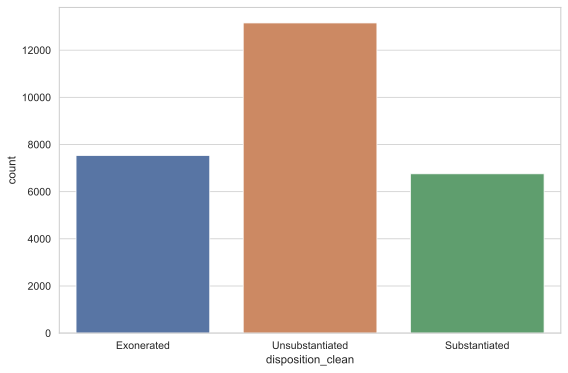

In [176]:
sns.countplot(df['disposition_clean'])

plt.savefig('../figures/disposition_distribution.png');

### Explore univariate distribution of features

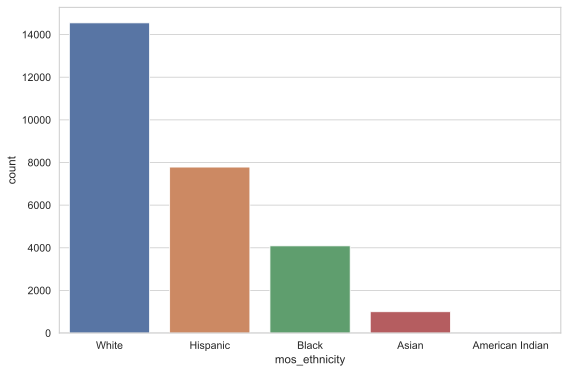

In [177]:
sns.countplot(df['mos_ethnicity'])
plt.savefig('../figures/mos_ethnicity_distribution.png');

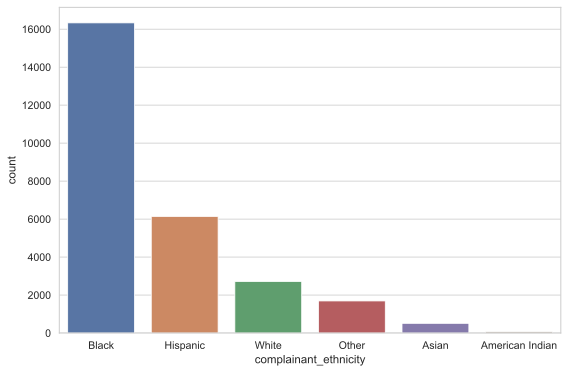

In [178]:
sns.countplot(df['complainant_ethnicity'])
plt.savefig('../figures/complainant_ethnicity_distribution.png');

Unsurprisingly, it does appear that black and hispanic folks are overrepresented in the complainant demographics; according to [census data](https://www.census.gov/quickfacts/newyorkcitynewyork), 42% of NYC residents are white, while 24% are Black and 29% are Hispanic or Latino.

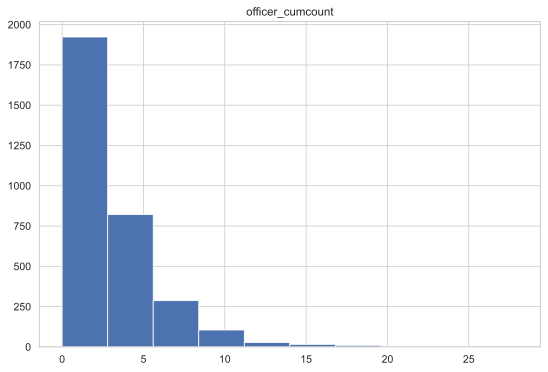

In [179]:
df.groupby('shield_no').agg({'officer_cumcount': 'max'}).hist();

While the vast majority of officers in the dataset have fewer than five complaints against them, there are some with quite a lot (10 or more).

### Explore feature relationships with targets

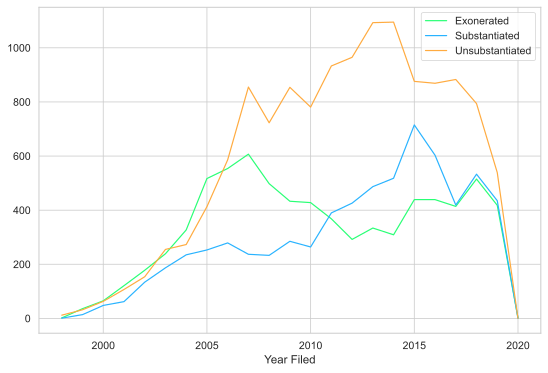

In [180]:
# create line chart of complaint volume by outcome over time
pd.crosstab(index=df['year_received'], columns=df['disposition_clean']).plot(style=['#29ff75','#29B3FF','#ffab40'])
plt.xlabel('Year Filed')
plt.legend(title=None);

# save image for presentation
plt.savefig('../figures/time_series_disposition.png')

Really interesting switch in the trend between exonerated and substantited complaints ~2011. I wonder if that was influenced by ongoing public outcry against NYC's stop and frisk policy, and specifically the [NYCLU lawsuit filed in 2011](https://www.nyclu.org/en/stop-and-frisk-data).

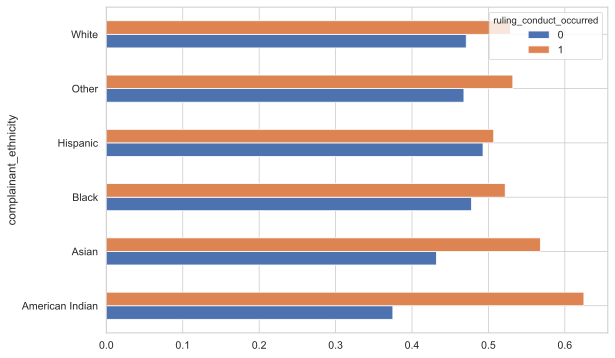

In [181]:
pd.crosstab(index=df['complainant_ethnicity'], columns=df['ruling_conduct_occurred'],
            normalize='index').round(3).plot(kind='barh');

plt.savefig('../figures/race_disposition_conductoccurred.png')

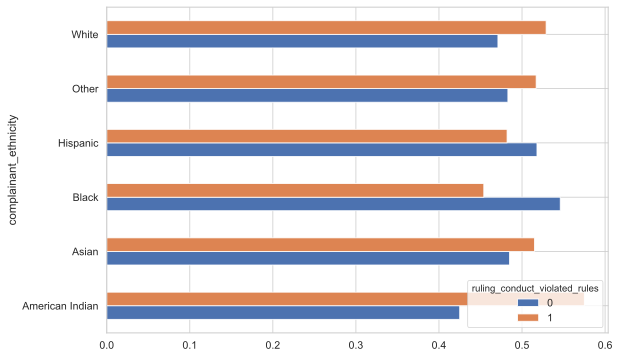

In [182]:
pd.crosstab(index=df_occurred['complainant_ethnicity'], columns=df_occurred['ruling_conduct_violated_rules'],
            normalize='index').round(3).plot(kind='barh');

plt.savefig('../figures/race_disposition_violatedrules.png')

Interesting. Looks like the complaint is much less likely to be ruled as "conduct violated rules" if the complainant ethnicity is Black/Hispanic. Further analysis could look at whether this hold true when controlling for complaint type.

Next I'll just glance at the bivariate relationships with some of the numeric features available...

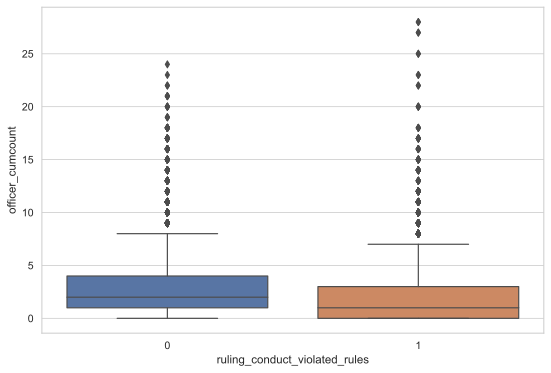

In [183]:
sns.boxplot(x= df_occurred['ruling_conduct_violated_rules'],y=df_occurred['officer_cumcount']);

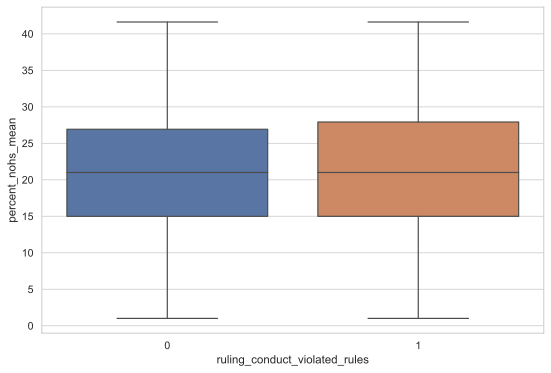

In [184]:
sns.boxplot(x= df_occurred['ruling_conduct_violated_rules'],y=df_occurred['percent_nohs_mean']);

## Write dataset to pickle for modeling

In [185]:
df.replace(to_replace=[None], value=np.nan, inplace=True)
with open('../data/processed_data.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

## Create and export datasets for observable 

### Complaint Count Bar Chart Race

In [186]:
# create field for officer full name -- although will use shield number in the public viz for now
df['full_name'] = df['first_name'] + " " + df['last_name']

#create list of the officers with the highest number of complaints against them
most_complaints =  df.groupby(['shield_no']).agg({'complaint_id': 'count'}).reset_index().sort_values('complaint_id', ascending=False).head(20)
most_complaints_list = list(most_complaints['shield_no'])

# create a dataframe for bar chart race
# contains 20 officers with highest number of complaints, and their cumulative count for each year 1985-2020
race_df = []
for o in most_complaints_list:
    for i in range(2000,2021,1):
        new_row = []
        annual_count = df[(df['shield_no']==o) & (df['year_received'] < i)]['complaint_id'].count()
        new_row.append(i)
        new_row.append(o)
        new_row.append(annual_count)
        race_df.append(new_row)
race_df = pd.DataFrame(race_df,columns=['date','shield_no','value'])
race_df['date'] = pd.to_datetime(race_df['date'], format='%Y')
race_df['shield_no'] = "Shield No. "+ race_df['shield_no'].astype(str)
race_df = race_df.rename(columns={"shield_no": "name"})

# drop the shield number=0 rows; that seems to be a placeholder
indexNames = race_df[ race_df['name'] == 'Shield No. 0' ].index
race_df = race_df.drop(indexNames)

race_df

,date,name,value
21,2000-01-01,Shield No. 122,0
22,2001-01-01,Shield No. 122,0
23,2002-01-01,Shield No. 122,0
24,2003-01-01,Shield No. 122,0
25,2004-01-01,Shield No. 122,0
...,...,...,...
415,2016-01-01,Shield No. 3436,39
416,2017-01-01,Shield No. 3436,39
417,2018-01-01,Shield No. 3436,39
418,2019-01-01,Shield No. 3436,39


In [187]:
race_df.to_csv('../data/bar_race_shield.csv')

### Sankey Diagram
Note: this dataframe was further manipulated in excel in order to mimic the json nodes and links format needed for D3

In [188]:
# create a cleaned up version of the "contact reason" field for the sankey digram
contact_reason_pct = df['contact_reason'].value_counts(normalize=True).cumsum()
other_contact_reasons = list(contact_reason_pct[contact_reason_pct > 0.9].index)
df['contact_reason_sankey'] = df['contact_reason'].replace(other_contact_reasons,'Other')

df['contact_reason_sankey']=df['contact_reason_sankey'].str.replace("PD suspected C/V of violation/crime - street","Suspected violation on street")
df['contact_reason_sankey']=df['contact_reason_sankey'].str.replace("PD suspected C/V of violation/crime - auto","Suspected violation in car")
df['contact_reason_sankey']=df['contact_reason_sankey'].str.replace("PD suspected C/V of violation/crime - bldg","Suspected violation in a bldg")
df['contact_reason_sankey']=df['contact_reason_sankey'].str.replace("Other violation of VTL","Moving/Traffic Violation")
df['contact_reason_sankey']=df['contact_reason_sankey'].str.replace("Moving violation","Moving/Traffic Violation")
df['contact_reason_sankey'].value_counts()

Other                            9529
Suspected violation on street    9088
Moving/Traffic Violation         2981
Suspected violation in car       2788
Suspected violation in a bldg    2062
Report-dispute                    877
Name: contact_reason_sankey, dtype: int64

In [189]:
# create sankey diagram dataframe
sankey = df.groupby(['contact_reason_sankey','fado_type','disposition_clean']).agg({'complaint_id': 'count'}).reset_index()
sankey.to_csv('../data/bar_race_shield.csv')

# send to excel for final processing
sankey.to_clipboard(excel=True)

In [190]:
sankey

,contact_reason_sankey,fado_type,disposition_clean,complaint_id
0,Moving/Traffic Violation,Abuse of Authority,Exonerated,613
1,Moving/Traffic Violation,Abuse of Authority,Substantiated,565
2,Moving/Traffic Violation,Abuse of Authority,Unsubstantiated,853
3,Moving/Traffic Violation,Discourtesy,Exonerated,24
4,Moving/Traffic Violation,Discourtesy,Substantiated,100
...,...,...,...,...
62,Suspected violation on street,Force,Exonerated,988
63,Suspected violation on street,Force,Substantiated,225
64,Suspected violation on street,Force,Unsubstantiated,945
65,Suspected violation on street,Offensive Language,Substantiated,18


In [191]:
nodes = list(sankey['contact_reason_sankey'].unique())+list(sankey['fado_type'].unique())+list(sankey['fado_type'].unique())
nodes

['Moving/Traffic Violation',
 'Other',
 'Report-dispute',
 'Suspected violation in a bldg',
 'Suspected violation in car',
 'Suspected violation on street',
 'Abuse of Authority',
 'Discourtesy',
 'Force',
 'Offensive Language',
 'Abuse of Authority',
 'Discourtesy',
 'Force',
 'Offensive Language']